In [9]:
import sys
# enable importing the modules from probcalkge
sys.path.append('../')
sys.path.append('../probcalkge')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from probcalkge import Experiment, ExperimentResult
from probcalkge import get_calibrators
from probcalkge import get_datasets,  get_kgemodels
from probcalkge import brier_score, negative_log_loss, ks_error, ece

In [2]:
cals = get_calibrators()
kges = get_kgemodels()
ds = get_datasets()

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


In [3]:
exp = Experiment(
    cals=[cals.uncal, cals.platt, cals.isot, ], 
    datasets=[ds.fb13, ds.wn18, ds.yago39, ds.dp50, ds.nations, ds.kinship, ds.umls], 
    kges=[kges.transE, kges.complEx, kges.distMult, kges.hoLE], 
    metrics=[ece]
    )

In [30]:
from ampligraph.latent_features import TransE, ComplEx
from ampligraph.utils import save_model
from ampligraph.latent_features.regularizers import LPRegularizer
hyperparams = {
        'verbose': True,
        'epochs': 100,
        'regularizer': 'LP',

        # taken from https://arxiv.org/abs/1912.10000
        'k': 100,
        'optimizer': 'adam',
        'loss': 'nll',
        'eta': 20,
        'optimizer_params': {'lr': 1e-4},
        # 'epochs': 1000,
    }

model4 = TransE(**hyperparams)
model4.fit(ds.fb13.X_train)
save_model(model4, 'transE-fb13-reg.pkl')

Average TransE Loss:   1.036733: 100%|██████████| 100/100 [48:19<00:00, 28.99s/epoch]


In [6]:
hyperparams = {
        'verbose': True,
        'epochs': 300,

        # taken from https://arxiv.org/abs/1912.10000
        'k': 100,
        'optimizer': 'adam',
        'loss': 'pairwise',
        'eta': 20,
        'optimizer_params': {'lr': 1e-4},
        # 'epochs': 1000,
    }

model2 = ComplEx(**hyperparams)
model2.fit(ds.fb13.X_train)
save_model(model2, 'COmplex-fb13-1000-pairwise.pkl')

Average ComplEx Loss:   0.070795: 100%|██████████| 300/300 [6:12:19<00:00, 74.47s/epoch]  


In [17]:
from ampligraph.latent_features.regularizers import LPRegularizer
hyperparams = {
        'verbose': True,
        'epochs': 100,
        'regularizer': 'LP',

        # taken from https://arxiv.org/abs/1912.10000
        'k': 100,
        'optimizer': 'adam',
        'loss': 'self_adversarial',
        'eta': 20,
        'optimizer_params': {'lr': 1e-4},
        # 'epochs': 1000,
    }

model3 = ComplEx(**hyperparams)
model3.fit(ds.fb13.X_train)
save_model(model3, 'COmplex-fb13-1000-adver.pkl')

Average ComplEx Loss:   0.824892: 100%|██████████| 100/100 [2:20:26<00:00, 84.26s/epoch]  


(array([  578.,   718.,  1190.,  1781.,  2722.,  5212.,  6783., 11311.,
         5159., 12010.]),
 array([0.        , 0.0493    , 0.0986    , 0.1479    , 0.1972    ,
        0.2465    , 0.2958    , 0.3451    , 0.3944    , 0.44370002,
        0.493     ], dtype=float32),
 <BarContainer object of 10 artists>)

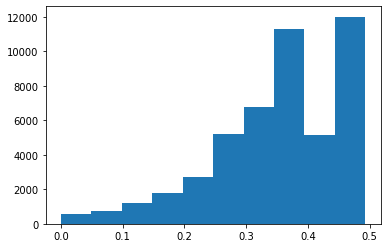

In [39]:
probs = expit(2*model4.predict(ds.fb13.X_test)).round(3)
accuracy_score(ds.fb13.y_test, probs>0.5)
plt.hist(probs)

In [4]:
exp.load_trained_kges('../saved_models')

Loaded models:
{'COmplex': OrderedDict([('fb13-1000-adver',
                          <ampligraph.latent_features.models.ComplEx.ComplEx object at 0x000001E362539788>),
                         ('fb13-1000-pairwise',
                          <ampligraph.latent_features.models.ComplEx.ComplEx object at 0x000001E365B45D48>)]),
 'DBpedia50': {'ComplEx': <ampligraph.latent_features.models.ComplEx.ComplEx object at 0x000001E365B45DC8>,
               'DistMult': <ampligraph.latent_features.models.DistMult.DistMult object at 0x000001E35F7FCDC8>,
               'HolE': <ampligraph.latent_features.models.HolE.HolE object at 0x000001E35F747848>,
               'TransE': <ampligraph.latent_features.models.TransE.TransE object at 0x000001E36A7C2048>},
 'DBpedia_ET': OrderedDict([('ComplEx',
                             <ampligraph.latent_features.models.ComplEx.ComplEx object at 0x000001E36A84D048>),
                            ('DistMult',
                             <ampligraph.latent_feature

In [5]:
from ampligraph.latent_features import TransE, ComplEx
from ampligraph.utils import save_model
from sklearn.metrics import accuracy_score
from scipy.special import expit


(array([  415.,    77.,    39.,    83.,   319.,   996.,  3332.,  9765.,
        18823., 13615.]),
 array([8.1775198e-04, 9.7917408e-02, 1.9501707e-01, 2.9211673e-01,
        3.8921639e-01, 4.8631606e-01, 5.8341569e-01, 6.8051535e-01,
        7.7761501e-01, 8.7471467e-01, 9.7181433e-01], dtype=float32),
 <BarContainer object of 10 artists>)

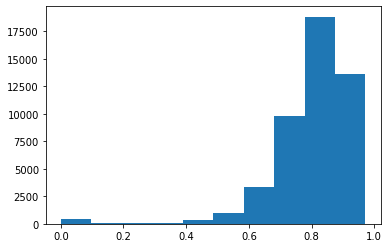

In [11]:
fb = ds.fb13
transe_fb = exp.trained_kges[fb.name]['TransE']
scores = transe_fb.predict(fb.X_test)
probs = expit(scores)*2
plt.hist(probs)

(array([5.1500e+02, 7.0000e+00, 1.3000e+01, 9.2000e+01, 6.7400e+02,
        1.3470e+03, 2.8900e+03, 7.6860e+03, 1.7173e+04, 1.7067e+04]),
 array([0.00182334, 0.10094581, 0.20006828, 0.29919076, 0.39831322,
        0.4974357 , 0.59655815, 0.6956806 , 0.7948031 , 0.89392555,
        0.993048  ], dtype=float32),
 <BarContainer object of 10 artists>)

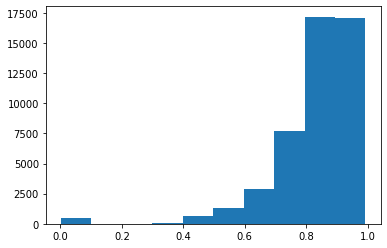

In [13]:
from ampligraph.utils import restore_model
reg_transe = restore_model('../saved_models/transE-fb13-reg.pkl')
scores = reg_transe.predict(fb.X_test)
probs = expit(scores)*2
plt.hist(probs)

In [15]:
accuracy_score(fb.y_test, probs>0.5)

0.47884712624304737

0.49995786280128096

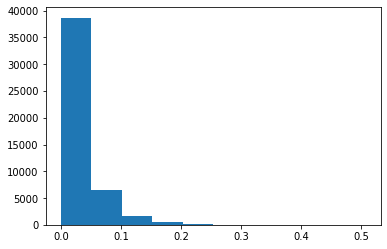

In [21]:
pairwise_complex = restore_model(r'C:\Users\s1904162\Downloads\kgcal\saved_models\COmplex-fb13-1000-adver.pkl')
scores = pairwise_complex.predict(fb.X_test)
probs = expit(scores)
plt.hist(probs)
accuracy_score(fb.y_test, probs>0.5)

0.5538934771616383

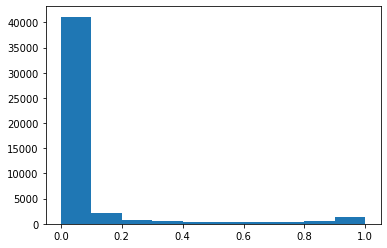

In [20]:
nll_complex = exp.trained_kges[fb.name]['ComplEx']
scores = nll_complex.predict(fb.X_test)
probs = expit(scores)
plt.hist(probs)
accuracy_score(fb.y_test, probs>0.5)

In [22]:
yago = ds.yago39
comp = ComplEx(loss='nll', verbose=True)
comp.fit(yago.X_train)

Average ComplEx Loss:   0.064539: 100%|██████████| 100/100 [24:04<00:00, 14.44s/epoch]


In [23]:
comp2 = ComplEx(loss='nll', verbose=True, regularizer='LP')
comp2.fit(yago.X_train)

Average ComplEx Loss:   0.066440: 100%|██████████| 100/100 [30:59<00:00, 18.60s/epoch]


0.8969968672356055

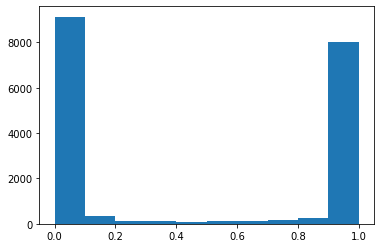

In [25]:
scores = comp.predict(yago.X_test)
probs = expit(scores)
plt.hist(probs)
accuracy_score(yago.y_test, probs>0.5)

0.8969428540563897

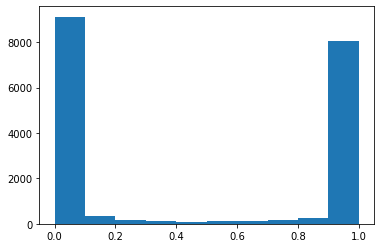

In [26]:
scores = comp2.predict(yago.X_test)
probs = expit(scores)
plt.hist(probs)
accuracy_score(yago.y_test, probs>0.5)